# 1. Load data

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection, metrics
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

pd.options.mode.chained_assignment = None
sns.mpl.rc("figure", figsize=(15,8))

df_base = pd.read_csv('bank-classification.csv')

# Change type of results column
df_base.y.replace(('yes', 'no'), (1, 0), inplace=True)

# Transform strings into datetimes
df_base['birth_date'] = pd.to_datetime(df_base['birth_date'], format='%Y-%m-%d')
df_base['contact_date'] = pd.to_datetime(df_base['contact_date'], format='%Y-%m-%d')


# 2. Feature engineering

In [2]:
df = df_base.copy()

### New feature - contact weekday

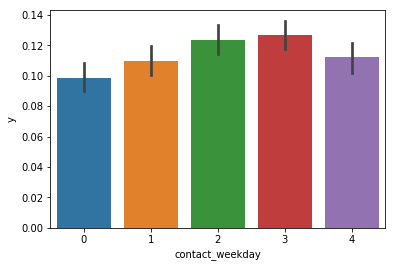

In [3]:
df['contact_weekday'] = df['contact_date'].apply(lambda x: x.weekday())

learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='contact_weekday', y='y', data=learn)
plt.show()

### New feature - contact month

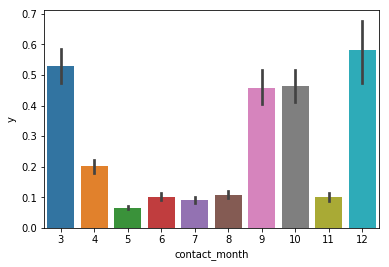

In [4]:
df['contact_month'] = df['contact_date'].apply(lambda x: x.month)

learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='contact_month', y='y', data=learn)
plt.show()

### New feature - contact day

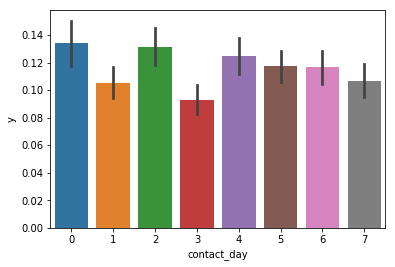

In [5]:
df['contact_day'] = df['contact_date'].apply(lambda x: x.day/4)

learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='contact_day', y='y', data=learn)
plt.show()

### New feature - birth month

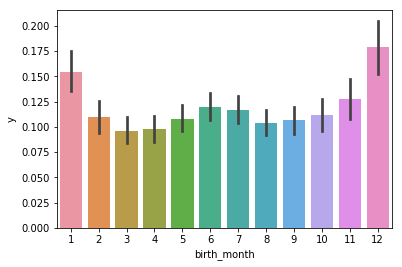

In [6]:
df['birth_month'] = df['birth_date'].apply(lambda x: x.month)

learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='birth_month', y='y', data=learn)
plt.show()

### Feature - job

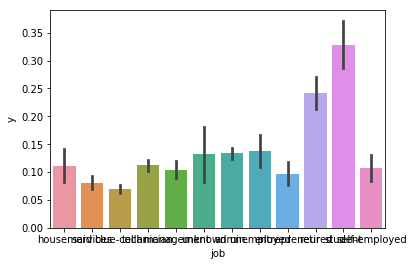

In [7]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='job', y='y', data=learn)
plt.show()


df['job'] = df.job.astype('category').cat.codes
#df = pd.get_dummies(df, columns=['job'], sparse=True)

### Feature - marital

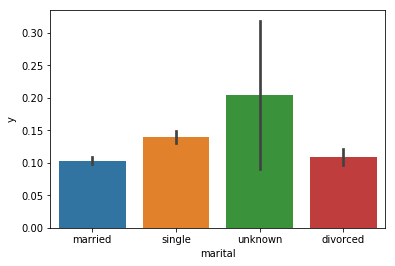

In [8]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='marital', y='y', data=learn)
plt.show()

df['marital'] = df.marital.astype('category').cat.codes
#df = pd.get_dummies(df, columns=['marital'], sparse=True)

### Feature - education

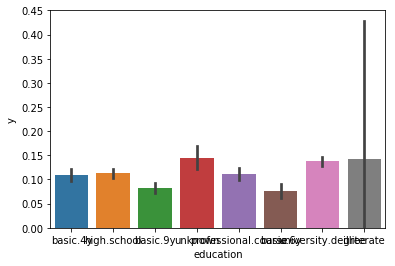

In [9]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='education', y='y', data=learn)
plt.show()

df['education'] = df.education.astype('category').cat.codes
#df = pd.get_dummies(df, columns=['education'], sparse=True)

### Feature - default

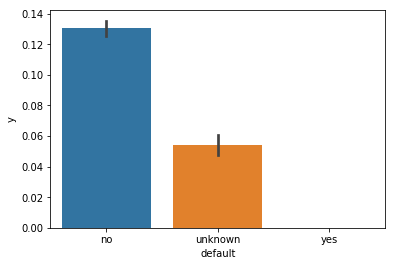

In [10]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='default', y='y', data=learn)
plt.show()

df['default'] = df.default.astype('category').cat.codes
#df = pd.get_dummies(df, columns=['default'], sparse=True)

### Feature - housing

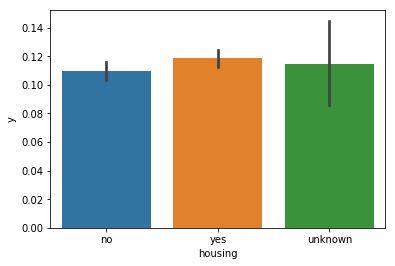

In [11]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='housing', y='y', data=learn)
plt.show()

#df = pd.get_dummies(df, columns=['housing'])

### Feature - loan

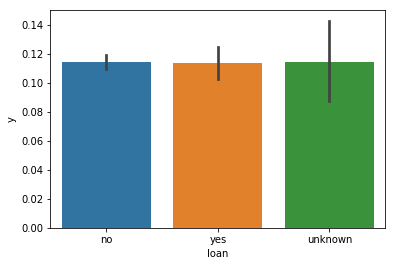

In [12]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='loan', y='y', data=learn)
plt.show()

#df = pd.get_dummies(df, columns=['loan'])

### Feature - contact

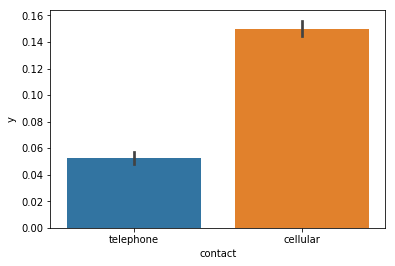

In [13]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='contact', y='y', data=learn)
plt.show()

df.contact.replace(('cellular', 'telephone'), (1, 0), inplace=True)

### Feature - pdays 

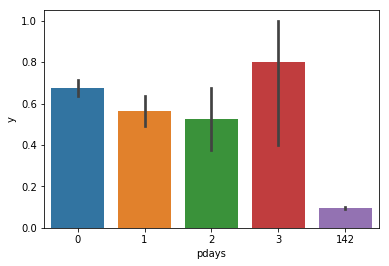

In [14]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
learn['pdays'] = learn['pdays'].apply(lambda x: x/7)
sns.barplot(x='pdays', y='y', data=learn)
plt.show()

df['pdays'] = df['pdays'].apply(lambda x: x/7)
# becacuse highest value has not much in common with others, let's one hot this feature
#df = pd.get_dummies(df, columns=['pdays'])

### Feature - campaign

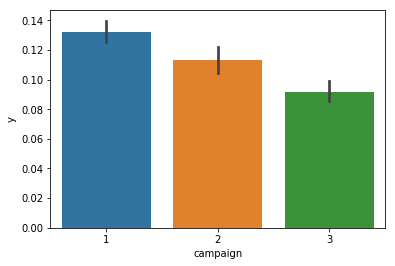

In [15]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
#learn['campaign'] = learn['campaign'].apply(lambda x: x/4)
learn.loc[learn.campaign > 2, 'campaign'] = 3
sns.barplot(x='campaign', y='y', data=learn)
plt.show()

#df['campaign'] = df['campaign'].apply(lambda x: x/4)
df.loc[df.campaign > 2, 'campaign'] = 3

### Feature - contact_date

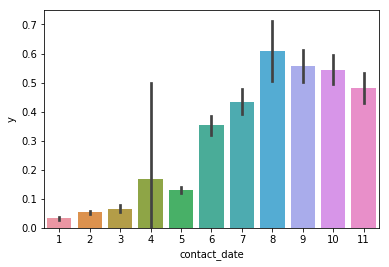

In [16]:
learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
learn['contact_date'] = learn['contact_date'].apply(lambda x: (x.month + (x.year-2008)*12)/3)
sns.barplot(x='contact_date', y='y', data=learn)
plt.show()

df['contact_date'] = df['contact_date'].apply(lambda x: (x.month + (x.year-2008)*12)/3)

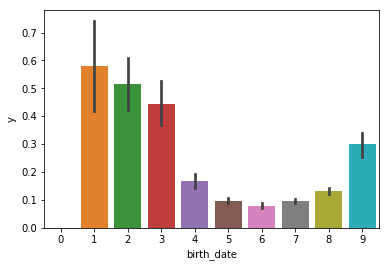

In [17]:
learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
learn['birth_date'] = learn['birth_date'].apply(lambda x: (x.month + (x.year-1910)*12)/100)
sns.barplot(x='birth_date', y='y', data=learn)
plt.show()

df['birth_date'] = df['birth_date'].apply(lambda x: (x.month + (x.year-1910)*12)/100)
#df = pd.get_dummies(df, columns=['birth_date'])

### Feature - poutcome

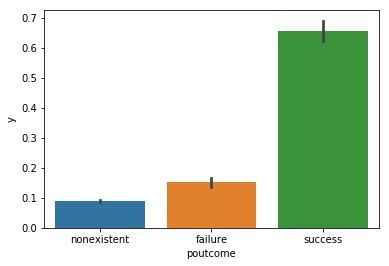

In [18]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='poutcome', y='y', data=learn)
plt.show()

df['poutcome'] = df.poutcome.astype('category').cat.codes
#df = pd.get_dummies(df, columns=['poutcome'], sparse=True)

### Table types

In [19]:
for i in df.columns, df.dtypes:
    print i

Index([u'id', u'birth_date', u'job', u'marital', u'education', u'default',
       u'housing', u'loan', u'contact_date', u'contact', u'campaign', u'pdays',
       u'previous', u'poutcome', u'y', u'contact_weekday', u'contact_month',
       u'contact_day', u'birth_month'],
      dtype='object')
id                  int64
birth_date          int64
job                  int8
marital              int8
education            int8
default              int8
housing            object
loan               object
contact_date        int64
contact             int64
campaign            int64
pdays               int64
previous            int64
poutcome             int8
y                  object
contact_weekday     int64
contact_month       int64
contact_day         int64
birth_month         int64
dtype: object


# 4. Learning

In [20]:
# Split data into learning and testing rows
learn = df.loc[df['y'] != 'unknown']
test = df.loc[df['y'] == 'unknown']
learn['y'] = learn['y'].astype('int64')
learn = shuffle(learn)

#predicators = ['contact_cellular', 'contact_telephone', 'poutcome_success', 'poutcome_nonexistent', 'poutcome_nonexistent', 'loan_no', 'loan_yes', 'loan_unknown', 'housing_unknown', 'housing_yes', 'housing_no', 'previous', 'default_no', 'default_yes', 'default_unknown']
predictors = [x for x in learn.columns if x not in ['y', 'loan', 'housing']]
params_ranges = {'n_estimators': [40, 200],
                 'min_samples_split': [150, 500],
                 'min_samples_leaf': [50, 100],
                 'max_depth': [5, 8],
                 'subsample': [0.5, 0.9]}

classifier = GradientBoostingClassifier(learning_rate=0.05, max_features='sqrt', random_state=13)
gsearch = RandomizedSearchCV(estimator = classifier, param_distributions=params_ranges, scoring='roc_auc', n_jobs=8, iid=False, cv=5)

gsearch.fit(learn[predictors], learn['y'])

print gsearch.best_params_, gsearch.best_score_


{'n_estimators': 40, 'subsample': 0.9, 'min_samples_split': 500, 'max_depth': 8, 'min_samples_leaf': 50} 0.793154106546


In [ ]:
dtrain_predictions = gsearch.predict(learn[predictors])
cv_score = model_selection.cross_val_score(gsearch, learn[predictors], learn['y'], cv=10, scoring='roc_auc')
dtrain_predprob = gsearch.predict_proba(learn[predictors])[:,1]

In [ ]:
print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(learn['y'].values, dtrain_predictions)
print "AUC Score (Train): %f" % metrics.roc_auc_score(learn['y'], dtrain_predprob)
print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))

In [21]:
parameters = {
    'max_depth': 7,
    'learning_rate': 0.1,
    'min_samples_split': 200,
    'min_samples_leaf': 50,
    'max_features': 14,
    'subsample': 0.75,
    'n_estimators': 30,
}

grid1 = GridSearchCV(estimator = GradientBoostingClassifier(**parameters),
                     param_grid = {'n_estimators':range(34, 48, 1)}, 
                     scoring='roc_auc',
                     n_jobs=-1,
                     cv=15)

grid1.fit(learn[predictors], learn['y'])
print grid1.best_params_, grid1.best_score_

parameters['n_estimators'] = grid1.best_params_['n_estimators']

{'n_estimators': 44} 0.798999536262


In [22]:
grid2 = GridSearchCV(estimator = GradientBoostingClassifier(**parameters),
                     param_grid = {'max_depth':range(5,11,1), 'min_samples_split':range(100, 201, 10)},
                     scoring='roc_auc',
                     n_jobs=-1,
                     cv=5)

grid2.fit(learn[predictors], learn['y'])
print grid2.best_params_, grid2.best_score_


parameters['max_depth'] = grid2.best_params_['max_depth']

{'min_samples_split': 100, 'max_depth': 6} 0.798337234372


In [23]:
grid3 = GridSearchCV(estimator = GradientBoostingClassifier(**parameters),
                     param_grid = {'min_samples_split':range(200, 250, 5), 'min_samples_leaf':range(20, 30, 1)},
                     scoring='roc_auc',
                     n_jobs=-1,
                     cv=5)

grid3.fit(learn[predictors], learn['y'])
print grid3.best_params_, grid3.best_score_


parameters['min_samples_split'] = grid3.best_params_['min_samples_split']
parameters['min_samples_leaf'] = grid3.best_params_['min_samples_leaf']

{'min_samples_split': 215, 'min_samples_leaf': 22} 0.798861840784


In [33]:
grid4 = GridSearchCV(estimator = GradientBoostingClassifier(**parameters),
                     param_grid = {'max_features':range(4,13,1)},
                     scoring='roc_auc',
                     n_jobs=-1,
                     cv=15)

grid4.fit(learn[predictors], learn['y'])
print grid4.best_params_, grid4.best_score_


parameters['max_features'] = grid4.best_params_['max_features']

{'max_features': 10} 0.797287075611


In [35]:
grid5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=27, max_depth=8, min_samples_split=240, min_samples_leaf=23, subsample=0.8, max_features=15),
                     param_grid = {'subsample': np.linspace(0.5, 0.9, 21)},
                     scoring='roc_auc',
                     n_jobs=-1,
                     cv=15)

grid5.fit(learn[predictors], learn['y'])
print grid5.best_params_, grid5.best_score_


parameters['subsample'] = grid5.best_params_['subsample']

{'subsample': 0.90000000000000002} 0.799113713638


In [36]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['y'])
        
    #Predict training set:
    
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['y'], dtrain_predprob)
    
    #Perform cross-validation:
    if performCV:
        cv_score = model_selection.cross_val_score(alg, dtrain[predictors], dtrain['y'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

AUC Score (Train): 0.878320
CV Score : Mean - 0.7959757 | Std - 0.0091274 | Min - 0.7814818 | Max - 0.8068365


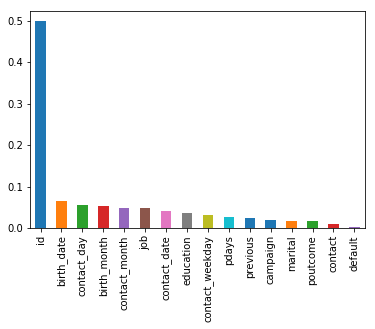

In [39]:
parameters2 = dict(parameters)
parameters2['learning_rate'] = 0.01
parameters2['n_estimators'] = 50 * parameters['n_estimators']

tune1 = GradientBoostingClassifier(**parameters2)

tune1.fit(learn[predictors], learn['y'])
dtrain_predprob = tune1.predict_proba(learn[predictors])[:,1]
print "AUC Score (Train): %f" % metrics.roc_auc_score(learn['y'], dtrain_predprob)

cv_score = model_selection.cross_val_score(tune1, learn[predictors], learn['y'], cv=5, scoring='roc_auc')
print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))

feat_imp = pd.Series(tune1.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar')

# 5. Predict

In [31]:
test = df.loc[df['y'] == 'unknown']
results = tune1.predict_proba(test[predictors])
test['y'] = results
test[['id', 'y']].to_csv("results.csv", encoding='utf-8', index=False)

In [43]:
# {'subsample': 0.90000000000000002, 'learning_rate': 0.1, 'min_samples_leaf': 22, 'n_estimators': 44, 'max_features': 10, 'min_samples_split': 215, 'max_depth': 6}

{'subsample': 0.90000000000000002, 'learning_rate': 0.1, 'min_samples_leaf': 22, 'n_estimators': 44, 'max_features': 10, 'min_samples_split': 215, 'max_depth': 6}
